# How do GDP affect the art themes produced in the US?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 4/02/25

**Authors**: Chiara Franzin

**Objective**:🌟 Visualise how art themes and GDP correlate

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib as mpl
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import colorsys
import plotly.io as pio
import sqlite3
import seaborn as sns
from sqlalchemy import create_engine



## 1. Processing Data from SQLite Database

### 1.1 Smithsonian Data

In [116]:
# Connect to the database
engine = create_engine('sqlite:///../../data/processed/social_movements.db')

# Query topics
df = pd.read_sql_query(
    "SELECT Topics FROM SmithsonianArtworks WHERE ProductionYear BETWEEN 1920 AND 2010 AND Topics != 'None'",
    con=engine
)

# Split the comma-separated topics into separate rows
df['Topics'] = df['Topics'].str.split(', ')  # Split into lists
df_topics = df.explode('Topics')  # Convert lists into separate rows

# Count occurrences of individual themes
df_counts = df_topics['Topics'].value_counts().reset_index()
df_counts.columns = ['Topic', 'ThemeCount']

df_counts.head()


,Topic,ThemeCount
0,Landscapes,610
1,Architecture,566
2,Botanical study,438
3,Figure group,392
4,Animals,338


In [117]:
df_counts.head(20)


,Topic,ThemeCount
0,Landscapes,610
1,Architecture,566
2,Botanical study,438
3,Figure group,392
4,Animals,338
5,Portraits,324
6,Occupations,296
7,Men,277
8,Cityscapes,218
9,Figure female,201


I'm going to remove "art" as an art theme because it is too vague and if I left it and did analysis on it, it would reveal nothing about the type of art that is created.

In [118]:
# Remove 'Art' from the topics
df_counts2 = df_counts[df_counts['Topic'] != 'Art']

# Display the top 20 remaining topics
df_top20 = df_counts2.head(20)

df_top20

,Topic,ThemeCount
0,Landscapes,610
1,Architecture,566
2,Botanical study,438
3,Figure group,392
4,Animals,338
5,Portraits,324
6,Occupations,296
7,Men,277
8,Cityscapes,218
9,Figure female,201


Now I want to find out how many paintings are created in each topic/theme every decade from the 1920s to 2010s.

In [119]:
# Query topics and production years
df = pd.read_sql_query(
    "SELECT ProductionYear, Topics FROM SmithsonianArtworks WHERE ProductionYear BETWEEN 1920 AND 2010 AND Topics != 'None'",
    con=engine
)

# Split the comma-separated topics into separate rows
df['Topics'] = df['Topics'].str.split(', ')  
df_topics = df.explode('Topics')  

# Now the ProductionYear column is intact along with the exploded Topics column
# Add 'Decade' column based on 'ProductionYear'
df_topics['Decade'] = df_topics['ProductionYear'] // 10 * 10

# Filter to only include the top 20 themes
top_20_themes = df_top20['Topic'].tolist()
df_topics_filtered = df_topics[df_topics['Topics'].isin(top_20_themes)]

# Count occurrences of each theme by decade
df_counts_filtered_by_decade = df_topics_filtered.groupby(['Decade', 'Topics']).size().reset_index(name='ThemeCount')

# Pivot the table so that decades are rows and the filtered themes are columns
df_pivot_filtered = df_counts_filtered_by_decade.pivot_table(index='Decade', columns='Topics', values='ThemeCount', aggfunc='sum', fill_value=0)

# Display the resulting table with the count of paintings created in each theme per decade
df_pivot_filtered


Topics,Animals,Architecture,Botanical study,Cityscapes,Clothing and dress,Domestic,Dress accessories,Figure female,Figure group,Figure male,Horses,Landscapes,Men,Mountains,Nudity,Occupations,Portraits,Religion,Trees,Women
Decade,,,,,,,,,,,,,,,,,,,,
1920,221,308,269,135,68,82,59,100,200,68,74,305,157,55,80,138,169,76,65,66
1930,67,156,152,52,33,42,32,73,108,39,18,200,62,26,43,69,88,40,34,47
1940,46,85,17,29,28,42,14,28,72,82,13,93,29,13,7,82,23,14,9,16
1950,1,8,0,0,1,5,0,0,4,1,0,5,2,1,0,2,4,3,1,2
1960,1,1,0,0,1,1,2,0,4,2,0,3,4,0,0,2,4,0,0,0
1970,0,4,0,2,0,0,1,0,2,0,0,2,0,0,0,1,1,0,0,2
1980,1,0,0,0,5,0,5,0,0,1,0,0,20,0,0,1,31,0,0,14
1990,1,2,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2000,0,2,0,0,1,0,1,0,2,1,0,1,3,1,0,0,3,0,0,0


This is the table I want, I will add it to csv file in the data/processed folder for future use.

In [120]:
output_folder = '../../data/processed'  
output_file = 'top_20_themes_by_decade.csv'  

output_path = f"{output_folder}/{output_file}"

df_pivot_filtered.to_csv(output_path)

output_path

'../../data/processed/top_20_themes_by_decade.csv'

### 1.2 FRED Data

In [121]:
df_gdp = pd.read_sql_query(
    "SELECT Date, GDP_Billions FROM FRED",
    con=engine
)

# Display the first few rows to check
df_gdp.head()


,Date,GDP_Billions
0,2023-01-01,22671.096
1,2022-01-01,22034.828
2,2021-01-01,21494.798
3,2020-01-01,20267.585
4,2019-01-01,20715.671


In [122]:
df_gdp.columns

Index(['Date', 'GDP_Billions'], dtype='object')

Since the art data is based on decades, I'm going to use the average GDP for every decade. Furthermore, the GDP I'm getting is limited to the period between 1920s and 2010s. This is because there is no FRED data available on the real GDP of the US available before the 1920s and there is no art data from Smithsonian available in the 2020s.

In [123]:
# Function to compute mean GDP for each decade
def get_mean_gdp_by_decade(df_gdp):
    # Convert the 'Date' column to datetime if not already in datetime format
    df_gdp['Date'] = pd.to_datetime(df_gdp['Date'])

    # Extract the decade by flooring the year to the nearest multiple of 10
    df_gdp['Decade'] = (df_gdp['Date'].dt.year // 10) * 10

    # Filter to get only data between 1920 and 2010
    df_gdp = df_gdp[df_gdp['Decade'].between(1920, 2010)]

    # Group by 'Decade' and calculate the mean GDP for each decade
    gdp_by_decade = df_gdp.groupby('Decade')['GDP_Billions'].mean().reset_index()

    return gdp_by_decade

# Call the function
df_gdp_decade = get_mean_gdp_by_decade(df_gdp)

# Display the result
df_gdp_decade


,Decade,GDP_Billions
0,1920,1191.1240
1,1930,1088.5694
2,1940,2140.2316
3,1950,2970.2267
4,1960,4369.1739
5,1970,6222.7444
6,1980,8373.9466
7,1990,11439.1799
8,2000,15544.0685
9,2010,18582.1763


I'm going to round the average GDP to 0 decimal points in order to keep all the tables and visualisations clear.

In [124]:
# Round the 'GDP_Billions' column to 0 decimal points
df_gdp_decade['GDP_Billions'] = df_gdp_decade['GDP_Billions'].round(0)

# Display the result
df_gdp_decade

,Decade,GDP_Billions
0,1920,1191.0
1,1930,1089.0
2,1940,2140.0
3,1950,2970.0
4,1960,4369.0
5,1970,6223.0
6,1980,8374.0
7,1990,11439.0
8,2000,15544.0
9,2010,18582.0


In [125]:
output_folder_path = '../../data/processed/'

# Save the dataframe to a CSV file in the specified folder
df_gdp_decade.to_csv(f'{output_folder_path}gdp_by_decade.csv', index=False)


# 2. Visualisation: Heatmap

In [126]:
gdp_data = pd.read_csv('../../data/processed/gdp_by_decade.csv')
GDP_by_decade_list = [f"${row['GDP_Billions']:.0f} bn in {row['Decade']}" 
                      for _, row in gdp_data.iterrows()]
GDP_by_decade = list(GDP_by_decade_list[:10])

print(GDP_by_decade)


art_data = pd.read_csv('../../data/processed/top_20_themes_by_decade.csv')
art_themes_list = list(art_data.columns[1:])

print(art_themes_list)

['$1191 bn in 1920.0', '$1089 bn in 1930.0', '$2140 bn in 1940.0', '$2970 bn in 1950.0', '$4369 bn in 1960.0', '$6223 bn in 1970.0', '$8374 bn in 1980.0', '$11439 bn in 1990.0', '$15544 bn in 2000.0', '$18582 bn in 2010.0']
['Animals', 'Architecture', 'Botanical study', 'Cityscapes', 'Clothing and dress', 'Domestic', 'Dress accessories', 'Figure female', 'Figure group', 'Figure male', 'Horses', 'Landscapes', 'Men', 'Mountains', 'Nudity', 'Occupations', 'Portraits', 'Religion', 'Trees', 'Women']


In [127]:
def create_theme_array(csv_file):
    # Read the CSV file
    data = pd.read_csv(csv_file)
    
    # Extract themes (columns excluding "Decade")
    themes = list(data.columns[1:])
    
    # Extract counts as a 2D NumPy array
    theme_counts = data.iloc[:, 1:].values  
    
    return themes, theme_counts

# Usage
csv_file = "../../data/processed/top_20_themes_by_decade.csv"  # Replace with your file path
themes, theme_array = create_theme_array(csv_file)

# Print the themes list
print("Themes:", themes)

# Print the NumPy array
print("Theme Counts Array:")
print(theme_array)

Themes: ['Animals', 'Architecture', 'Botanical study', 'Cityscapes', 'Clothing and dress', 'Domestic', 'Dress accessories', 'Figure female', 'Figure group', 'Figure male', 'Horses', 'Landscapes', 'Men', 'Mountains', 'Nudity', 'Occupations', 'Portraits', 'Religion', 'Trees', 'Women']
Theme Counts Array:
[[221 308 269 135  68  82  59 100 200  68  74 305 157  55  80 138 169  76
   65  66]
 [ 67 156 152  52  33  42  32  73 108  39  18 200  62  26  43  69  88  40
   34  47]
 [ 46  85  17  29  28  42  14  28  72  82  13  93  29  13   7  82  23  14
    9  16]
 [  1   8   0   0   1   5   0   0   4   1   0   5   2   1   0   2   4   3
    1   2]
 [  1   1   0   0   1   1   2   0   4   2   0   3   4   0   0   2   4   0
    0   0]
 [  0   4   0   2   0   0   1   0   2   0   0   2   0   0   0   1   1   0
    0   2]
 [  1   0   0   0   5   0   5   0   0   1   0   0  20   0   0   1  31   0
    0  14]
 [  1   2   0   0   0   2   0   0   0   0   0   1   0   0   0   1   0   0
    0   0]
 [  0   2   0   

The array above is the absolute number of art pieces made in every art theme each decade from 1920s to 2010s. While the array below is the percentage of each art theme made each year out of the total number of the top 20 art themes each year.


In [128]:
# Step 1: Calculate the sum of each row (total paintings in each decade)
decade_totals = np.sum(theme_array, axis=1)

# Step 2: Normalize the array to percentage values
percentage_array = (theme_array.T / decade_totals).T * 100  # Transpose to divide by row totals
percentage_array_rounded = np.round(percentage_array, 0)

# Now, percentage_array contains the percentage of paintings for each theme per decade
print(percentage_array_rounded)

[[ 8. 11. 10.  5.  3.  3.  2.  4.  7.  3.  3. 11.  6.  2.  3.  5.  6.  3.
   2.  2.]
 [ 5. 11. 11.  4.  2.  3.  2.  5.  8.  3.  1. 14.  4.  2.  3.  5.  6.  3.
   2.  3.]
 [ 6. 11.  2.  4.  4.  6.  2.  4. 10. 11.  2. 13.  4.  2.  1. 11.  3.  2.
   1.  2.]
 [ 2. 20.  0.  0.  2. 12.  0.  0. 10.  2.  0. 12.  5.  2.  0.  5. 10.  8.
   2.  5.]
 [ 4.  4.  0.  0.  4.  4.  8.  0. 16.  8.  0. 12. 16.  0.  0.  8. 16.  0.
   0.  0.]
 [ 0. 27.  0. 13.  0.  0.  7.  0. 13.  0.  0. 13.  0.  0.  0.  7.  7.  0.
   0. 13.]
 [ 1.  0.  0.  0.  6.  0.  6.  0.  0.  1.  0.  0. 26.  0.  0.  1. 40.  0.
   0. 18.]
 [14. 29.  0.  0.  0. 29.  0.  0.  0.  0.  0. 14.  0.  0.  0. 14.  0.  0.
   0.  0.]
 [ 0. 13.  0.  0.  7.  0.  7.  0. 13.  7.  0.  7. 20.  7.  0.  0. 20.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 50. 50.
   0.  0.]]


/var/folders/3q/69gq2v9d7rl3mwfgy8pbrn3h0000gn/T/ipykernel_93304/475285733.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



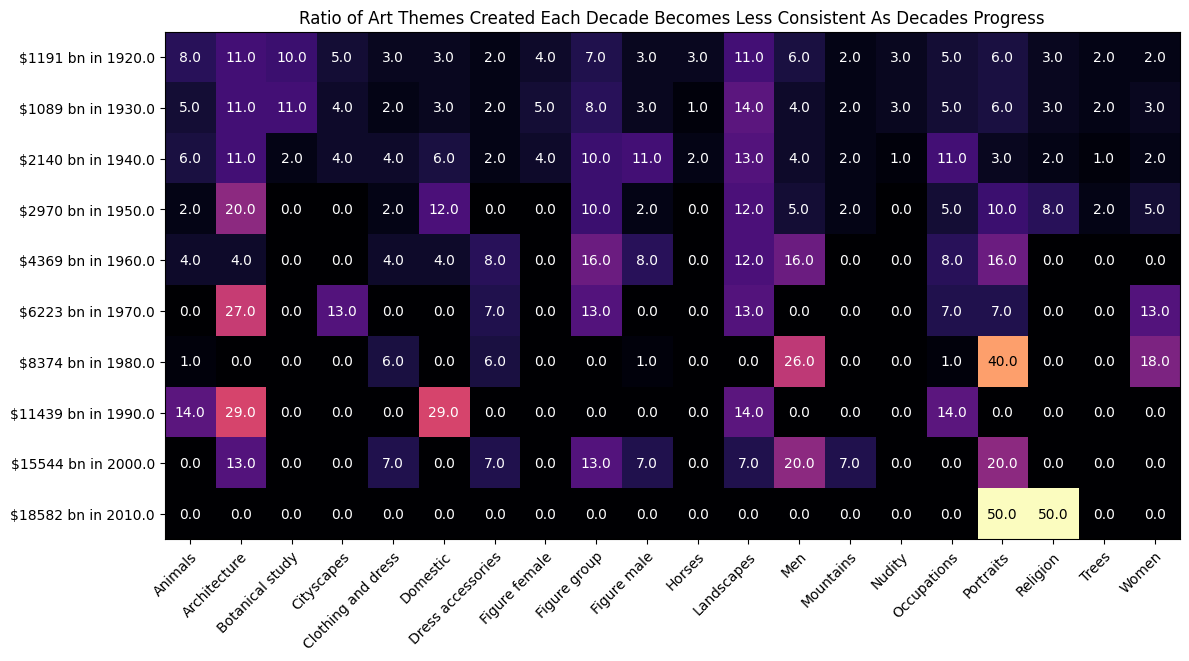

In [129]:
fig, ax = plt.subplots(figsize=(12, 8))
cmap = 'magma'  # this colormap is known to be accessible for people with colorblindness
im = ax.imshow(percentage_array_rounded, cmap=cmap)

# Make background transparent
fig.patch.set_alpha(0)
ax.patch.set_alpha(0) 

# Show all ticks and label them
ax.set_xticks(range(len(art_themes_list)), labels=art_themes_list, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(GDP_by_decade)), labels=GDP_by_decade)

# Normalize the data to colormap range
norm = mcolors.Normalize(vmin=np.min(percentage_array_rounded), vmax=np.max(percentage_array_rounded))
colormap = cm.get_cmap(cmap)

# Loop over data dimensions and create text annotations
for i in range(len(GDP_by_decade)):
    for j in range(len(art_themes_list)):
        value = percentage_array_rounded[i, j]
        color = colormap(norm(value))  # Get RGBA color from colormap
        brightness = (0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2])  # Compute perceived brightness
        
        text_color = "black" if brightness > 0.6 else "white"  # Switch text color if background is bright so that the writing is visible to everyone, irregardless of background colour
        
        ax.text(j, i, value, ha="center", va="center", color=text_color)

ax.set_title("Ratio of Art Themes Created Each Decade Becomes Less Consistent As Decades Progress")
fig.tight_layout()
plt.show()


fig.savefig("../../website/figures/heatmap.svg", dpi=300)

## 3. Visualisation: Interactive Line Graph

Below I made a variable that lists GDP in ascending order, so the first value of GDP (the lowest) actually represents 1930s while the second represents 1920s. The rest are also in ascending order of decades, e.g. the third item in the list is 1940s and the fourth is 1950s.

In [130]:
file_path = "../../data/processed/gdp_by_decade.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Extract the GDP values and sort them in ascending order
GDP_list = sorted(data['GDP_Billions'].tolist())

# Display the result
print(GDP_list)

[1089.0, 1191.0, 2140.0, 2970.0, 4369.0, 6223.0, 8374.0, 11439.0, 15544.0, 18582.0]


In [131]:
# Assuming theme_array is already defined
array_ordered = theme_array.copy()  # Create a copy to avoid modifying the original
array_ordered[[0, 1]] = array_ordered[[1, 0]]  # Swap the first two rows so that the rows are in increasing GDP order

print(array_ordered)


[[ 67 156 152  52  33  42  32  73 108  39  18 200  62  26  43  69  88  40
   34  47]
 [221 308 269 135  68  82  59 100 200  68  74 305 157  55  80 138 169  76
   65  66]
 [ 46  85  17  29  28  42  14  28  72  82  13  93  29  13   7  82  23  14
    9  16]
 [  1   8   0   0   1   5   0   0   4   1   0   5   2   1   0   2   4   3
    1   2]
 [  1   1   0   0   1   1   2   0   4   2   0   3   4   0   0   2   4   0
    0   0]
 [  0   4   0   2   0   0   1   0   2   0   0   2   0   0   0   1   1   0
    0   2]
 [  1   0   0   0   5   0   5   0   0   1   0   0  20   0   0   1  31   0
    0  14]
 [  1   2   0   0   0   2   0   0   0   0   0   1   0   0   0   1   0   0
    0   0]
 [  0   2   0   0   1   0   1   0   2   1   0   1   3   1   0   0   3   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1
    0   0]]


The interactive graph is shown below

In [132]:

art_themes = art_themes_list
GDP_by_decade = GDP_list
paintings_data = array_ordered

# Function to generate high-contrast colors
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = (i * 137.5) % 360  # Spread colors around the HSL wheel
        rgb = colorsys.hls_to_rgb(hue / 360, 0.4, 1.0)  # Ensure mid-brightness
        hex_color = "#{:02x}{:02x}{:02x}".format(
            int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
        )
        colors.append(hex_color)
    return colors

# Generate a color list with good contrast
colors = generate_colors(len(art_themes))

# Calculate the average effect of GDP on paintings
average_paintings = np.mean(paintings_data, axis=1)

# Initialize figure
fig = go.Figure()

# Add traces for each art theme
for i, theme in enumerate(art_themes):
    fig.add_trace(
        go.Scatter(
            x=GDP_by_decade,
            y=paintings_data[:, i],
            name=theme,
            visible=(i == 0),
            line=dict(color=colors[i])
        )
    )

# Add a trace for the average effect (initially hidden)
fig.add_trace(
    go.Scatter(
        x=GDP_by_decade,
        y=average_paintings,
        name="Average Effect",
        visible=False,  # Initially hidden
        line=dict(color="black", width=3, dash="dashdot")  # Black dashed line
    )
)

# Create dropdown menu options
dropdown_options = [
    {
        "label": "All Themes",
        "method": "update",
        "args": [
            {"visible": [True] * len(art_themes) + [False]},  # Show all themes, hide average
            {"title": "Popularity of All Art Themes vs. GDP"}
        ]
    },
    {
        "label": "Average Effect",
        "method": "update",
        "args": [
            {"visible": [False] * len(art_themes) + [True]},  # Hide all themes, show average
            {"title": "Average Effect of GDP on Number of Paintings"}
        ]
    }
]

# Add individual theme options
dropdown_options.extend([
    {
        "label": theme,
        "method": "update",
        "args": [
            {"visible": [j == i for j in range(len(art_themes))] + [False]},  # Show only selected theme, hide average
            {"title": f"Popularity of {theme} vs. GDP"}
        ]
    }
    for i, theme in enumerate(art_themes)
])

# Apply layout fixes (White background, black y-axis, dark gray x-axis)
fig.update_layout(
    width=900, 
    height=600, 
    paper_bgcolor="rgba(0,0,0,0)",  
    plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        showline=True,
        linecolor="black",
        linewidth=2,
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor="lightgray",
        showline=True, 
        linecolor="black",  
        linewidth=2, 
        range=[0, np.max(paintings_data)],
    ),
    updatemenus=[
        {
            "buttons": dropdown_options,
            "direction": "down",
            "showactive": True,
            "x": 0.15,  
            "y": 1.1
        }
    ],
    title="Popularity of Art Themes vs. GDP",
    xaxis_title="GDP in billions of US$",
    yaxis_title="Number of Paintings",
)

# Display the figure
fig.show()

# Save as an interactive HTML file
pio.write_html(fig, "../../website/figures/interactive_plot.html")
